In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [53]:
import os
os.getcwd()

'd:\\Neha\\BE\\final year project\\DTW_trial\\dtw'

In [ ]:
# Load frame range CSV
frame_range_df = pd.read_csv("../data/frame_range_BEST_11.csv")
# Load pose landmarks CSV
pose_landmarks_df = pd.read_csv("../data/pose_landmarks_BEST_11.csv")


In [55]:
pose_landmarks_df.head()
pose_landmarks_df = pose_landmarks_df.drop(columns=[col for col in pose_landmarks_df.columns if 'presence' in col])

In [56]:
pose_landmarks_df.head()


,class,video_index,frame,0_x,0_y,0_z,0_visibility,1_x,1_y,1_z,...,30_z,30_visibility,31_x,31_y,31_z,31_visibility,32_x,32_y,32_z,32_visibility
0,Animals_4. Bird,0,0,0.534613,0.245872,-0.493020,0.999839,0.542218,0.219161,-0.469746,...,0.211000,0.063768,0.549361,1.474423,0.013072,0.086523,0.477540,1.453923,0.060078,0.093143
1,Animals_4. Bird,0,1,0.538423,0.259539,-0.499790,0.999825,0.544779,0.234649,-0.475526,...,0.231806,0.061040,0.555331,1.502083,0.006980,0.082788,0.480264,1.495880,0.072257,0.087717
2,Animals_4. Bird,0,2,0.539836,0.260275,-0.476334,0.999787,0.546307,0.235338,-0.450949,...,0.164157,0.057549,0.552095,1.522504,0.050231,0.077011,0.486897,1.518266,-0.004100,0.082319
3,Animals_4. Bird,0,3,0.541286,0.263287,-0.449333,0.999700,0.548171,0.236494,-0.424534,...,0.161458,0.054882,0.552207,1.525507,0.048303,0.072440,0.485872,1.517892,-0.002725,0.078104
4,Animals_4. Bird,0,4,0.541737,0.260481,-0.446435,0.999595,0.548904,0.234125,-0.422154,...,0.150407,0.050770,0.550343,1.534520,0.016789,0.066455,0.485446,1.526786,-0.007056,0.071780


In [57]:
def expandPoints(points):
    cols = [0]*len(points)*3
    n = 0
    for i in points:
        for j in range(3):
            cols[n] = 3+4*i+j
            n+=1
    print(cols)
    return cols

pointsList =[0,7,8,11,12,13,14,15,16,17,18,19,20,21,22] 


In [58]:
pose_landmarks_df.head()

,class,video_index,frame,0_x,0_y,0_z,0_visibility,1_x,1_y,1_z,...,30_z,30_visibility,31_x,31_y,31_z,31_visibility,32_x,32_y,32_z,32_visibility
0,Animals_4. Bird,0,0,0.534613,0.245872,-0.493020,0.999839,0.542218,0.219161,-0.469746,...,0.211000,0.063768,0.549361,1.474423,0.013072,0.086523,0.477540,1.453923,0.060078,0.093143
1,Animals_4. Bird,0,1,0.538423,0.259539,-0.499790,0.999825,0.544779,0.234649,-0.475526,...,0.231806,0.061040,0.555331,1.502083,0.006980,0.082788,0.480264,1.495880,0.072257,0.087717
2,Animals_4. Bird,0,2,0.539836,0.260275,-0.476334,0.999787,0.546307,0.235338,-0.450949,...,0.164157,0.057549,0.552095,1.522504,0.050231,0.077011,0.486897,1.518266,-0.004100,0.082319
3,Animals_4. Bird,0,3,0.541286,0.263287,-0.449333,0.999700,0.548171,0.236494,-0.424534,...,0.161458,0.054882,0.552207,1.525507,0.048303,0.072440,0.485872,1.517892,-0.002725,0.078104
4,Animals_4. Bird,0,4,0.541737,0.260481,-0.446435,0.999595,0.548904,0.234125,-0.422154,...,0.150407,0.050770,0.550343,1.534520,0.016789,0.066455,0.485446,1.526786,-0.007056,0.071780


In [59]:
def preprocess_data(pose_landmarks_df, frame_range_df, pointsList):
    # Extract the correct columns based on landmark indices
    cols = expandPoints(pointsList)
    
    x_clips = []
    y_clips = []

    for _, row in frame_range_df.iterrows():
        sign_class = row['class']
        video_idx = row['video_index']
        start = row['start']
        end = row['end']

        # Check that the segment is exactly 45 frames
        if end - start != 45:
            continue  # skip if not 45 frames long

        # Filter the corresponding frames
        segment = pose_landmarks_df[
            (pose_landmarks_df['class'] == sign_class) &
            (pose_landmarks_df['video_index'] == video_idx) &
            (pose_landmarks_df['frame'] >= start) &
            (pose_landmarks_df['frame'] < end)
        ]

        if len(segment) != 45:
            continue  # extra sanity check

        # Extract features
        data = segment.iloc[:, cols].values  # shape: (45, num_features)

        x_clips.append(data)
        y_clips.append(sign_class)  # label per clip

    # Convert to arrays
    x_array = np.array(x_clips)  # shape: [num_clips, 45, num_features]

    #SCALER IS TURNED OFF!!
    # Scale each clip independently
    scaler = MinMaxScaler()
    x_array_scaled = np.array([scaler.fit_transform(clip) for clip in x_array])

    # Encode labels
    label_encoder = LabelEncoder()
    y_array = label_encoder.fit_transform(y_clips)  # shape: [num_clips]

    return x_array_scaled, y_array, label_encoder

x, y, label_encoder = preprocess_data(pose_landmarks_df,frame_range_df,pointsList)


[3, 4, 5, 31, 32, 33, 35, 36, 37, 47, 48, 49, 51, 52, 53, 55, 56, 57, 59, 60, 61, 63, 64, 65, 67, 68, 69, 71, 72, 73, 75, 76, 77, 79, 80, 81, 83, 84, 85, 87, 88, 89, 91, 92, 93]


In [60]:
print ('lbl:\n\n',label_encoder.inverse_transform(y))
print (y)

lbl:

 ['Adjectives_7. Deaf' 'Adjectives_7. Deaf' 'Adjectives_7. Deaf'
 'Adjectives_7. Deaf' 'Adjectives_7. Deaf' 'Adjectives_7. Deaf'
 'Adjectives_7. Deaf' 'Adjectives_7. Deaf' 'Animals_4. Bird'
 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird'
 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird'
 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird'
 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird' 'Animals_4. Bird'
 'Animals_4. Bird' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_39. Suit' 'Clothes_39. Suit'
 'Clothes_39. Suit' 'Clothes_40. Skirt' 'Clothes_40. Skirt'
 'Clothes_40. Skirt' 'Clothes_40. Skirt' 'Clothes_40. Skirt'
 'Clothes_40. Skirt' 'Clothes_40. Skirt' 'Cl

In [61]:
#for taking all sequences:

# from collections import defaultdict

# labels = label_encoder.inverse_transform(y)
# label_to_indices = defaultdict(list)
# for idx, label in enumerate(labels):
#     label_to_indices[label].append(idx)

# # take all sequences per label
# label_to_sequences = {
#     label: [x[i] for i in indices]
#     for label, indices in label_to_indices.items()
# }

In [62]:
from collections import defaultdict

# Group indices by label
labels = label_encoder.inverse_transform(y)
label_to_indices = defaultdict(list)
for idx, label in enumerate(labels):
    label_to_indices[label].append(idx)

# Sample sequences per label and store remaining separately
np.random.seed(44)  # for reproducibility
label_to_sequences = {}
label_to_remaining = {}

# 3 samples per class
for label, indices in label_to_indices.items():
    sampled_indices = np.random.choice(indices, size=3, replace=False)
    remaining_indices = list(set(indices) - set(sampled_indices))
    
    label_to_sequences[label] = [x[i] for i in sampled_indices]
    label_to_remaining[label] = [x[i] for i in remaining_indices]


In [63]:
label_to_sequences

{'Adjectives_7. Deaf': [array([[0.        , 0.        , 0.00371303, ..., 0.29919311, 0.9646634 ,
          0.40073881],
         [0.00415495, 0.02603502, 0.02816065, ..., 0.29012621, 0.95437735,
          0.412526  ],
         [0.0093903 , 0.02773525, 0.15815463, ..., 0.22740331, 0.91691371,
          0.45707657],
         ...,
         [0.97198766, 0.18864701, 0.06301402, ..., 0.18920546, 0.99674643,
          0.41778189],
         [0.98790333, 0.1850118 , 0.08229803, ..., 0.15808217, 0.98127637,
          0.42272837],
         [1.        , 0.18487598, 0.03282054, ..., 0.15693374, 0.98203475,
          0.40901051]]),
  array([[8.02718784e-01, 2.01781440e-02, 5.64213654e-01, ...,
          1.03221916e-01, 9.82958801e-01, 9.01577008e-01],
         [7.86493672e-01, 0.00000000e+00, 7.50414327e-01, ...,
          1.27454148e-01, 9.37259174e-01, 9.03069331e-01],
         [7.76406866e-01, 3.47792227e-04, 7.81753572e-01, ...,
          1.69311401e-01, 8.49223451e-01, 9.03343387e-01],
        

In [64]:
# %pip install fastdtw

In [65]:
# %pip install seaborn

In [66]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.metrics import classification_report, accuracy_score

true_labels = []
pred_labels = []

# DTW classification
for true_label, test_seqs in label_to_remaining.items():
    for test_seq in test_seqs:
        best_label = None
        best_distance = float('inf')

        for label, template_seqs in label_to_sequences.items():
            for template_seq in template_seqs:
                dist, _ = fastdtw(test_seq, template_seq, dist=euclidean)
                if dist < best_distance:
                    best_distance = dist
                    best_label = label

        true_labels.append(true_label)
        pred_labels.append(best_label)

# Metrics
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels))


Accuracy: 0.9432624113475178

Classification Report:

                                          precision    recall  f1-score   support

                      Adjectives_7. Deaf       0.62      1.00      0.77         5
                         Animals_4. Bird       1.00      0.93      0.97        15
                        Clothes_39. Suit       1.00      1.00      1.00        15
                       Clothes_40. Skirt       1.00      0.93      0.97        15
Means_of_Transportation_16. train ticket       1.00      0.88      0.93        16
                      People_66. Brother       1.00      0.81      0.90        16
                        Places_19. House       0.89      1.00      0.94        17
                        Places_23. Court       0.89      1.00      0.94        17
                Places_28. Store or Shop       0.94      1.00      0.97        16
                        Seasons_64. Fall       1.00      1.00      1.00         5
                        Society_2. Death   

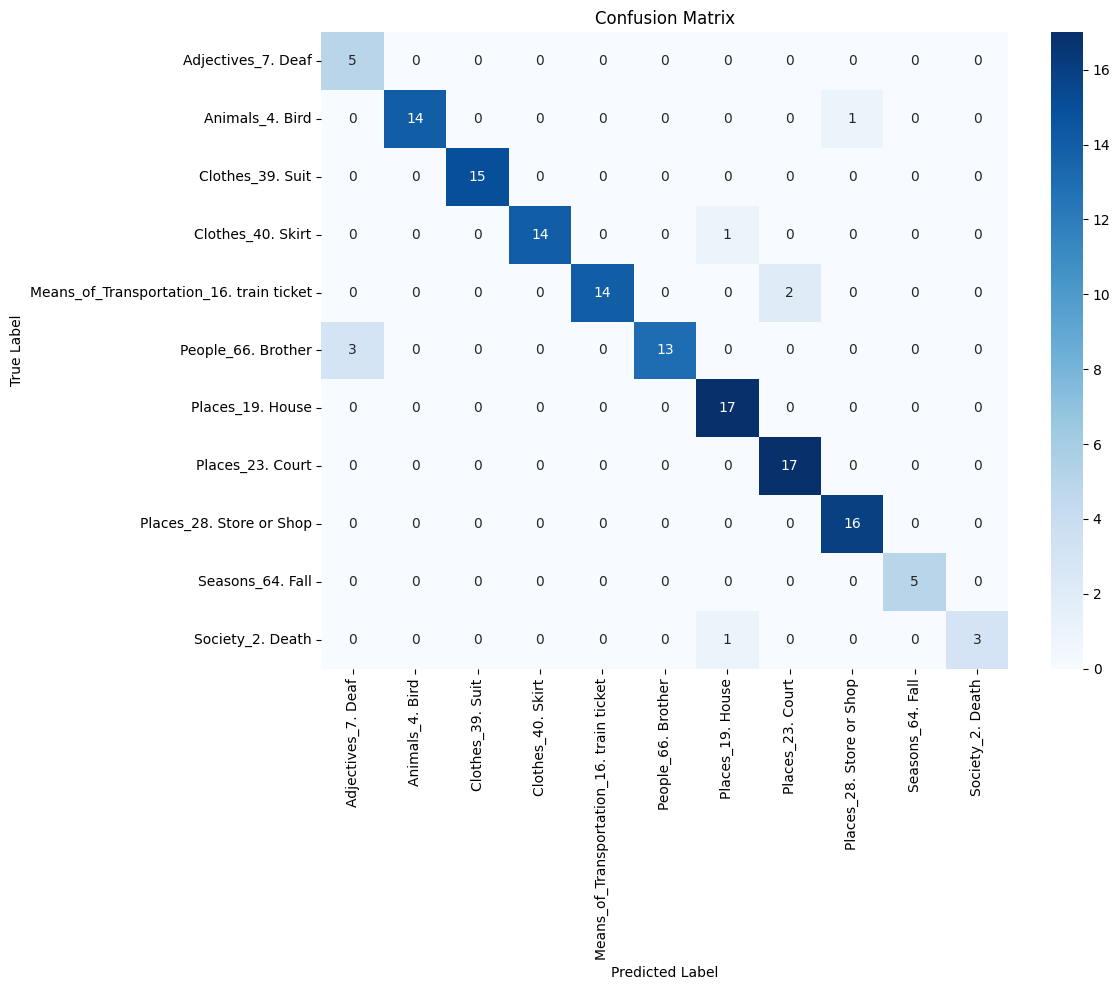

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(label_to_sequences.keys()))

# Plot as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_to_sequences.keys()),
            yticklabels=list(label_to_sequences.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [68]:
import pickle
with open('../data/dtw_templates_best_of_all.pkl', 'wb') as f:
    pickle.dump(label_to_sequences, f)